# <font color = 'pickle'> Install Libraries/ Set Google Colab

In [4]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install --upgrade fastai timm kaggle -qq
  base_folder = Path('/content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle')
  data_folder = Path('/content') #keep data on colab #org dataset size - 16gb and in class is 50mb


Running on CoLab
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00


# <font color = 'pickle'> Specify Project Folder

In [ ]:
#specifying datafolders
kaggle_api = base_folder/'.kaggle'
data_folder = data_folder/'inclass_kaggle_data'
model_folder = base_folder/'Models'
archive_folder  = data_folder/'archive'

In [ ]:
data_folder.mkdir(exist_ok=True)
kaggle_api.mkdir(exist_ok=True)
model_folder.mkdir(exist_ok=True, parents=True)
archive_folder.mkdir(exist_ok=True)


In [ ]:
import os
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle/.kaggle"

In [ ]:
if 'google.colab' in str(get_ipython()):
    !chmod 600 /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle/.kaggle/kaggle.json

In [ ]:
if 'google.colab' in str(get_ipython()):
    ! ls -la  /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle/.kaggle/kaggle.json

-rw------- 1 root root 73 Nov 27 17:24 /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle/.kaggle/kaggle.json


# <font color = 'pickle'> Import Libraries

In [ ]:
import fastai; fastai.__version__

'2.7.13'

In [ ]:
from fastai.vision.all import *
from kaggle import api
from zipfile import ZipFile
import timm

# <font color = 'pickle'> Get Data from kaggle

In [ ]:
! kaggle competitions download inclassplantpathologysmallf23 -p {archive_folder}


 99% 549M/552M [00:04<00:00, 177MB/s]
100% 552M/552M [00:04<00:00, 131MB/s]


In [ ]:
file = archive_folder/'inclassplantpathologysmallf23.zip'
with ZipFile(file , 'r') as f:
    filenames = f.namelist()

In [ ]:
filenames[0:10]

['sample_submission.csv',
 'test/test/test_image_1.jpg',
 'test/test/test_image_10.jpg',
 'test/test/test_image_100.jpg',
 'test/test/test_image_1000.jpg',
 'test/test/test_image_1001.jpg',
 'test/test/test_image_1002.jpg',
 'test/test/test_image_1003.jpg',
 'test/test/test_image_1004.jpg',
 'test/test/test_image_1005.jpg']

In [ ]:
with ZipFile(file ,'r') as f:
 f.extractall(path = data_folder)

# <font color = 'pickle'> Understand Data

In [ ]:
train_path = data_folder/'train/train'

In [ ]:
files = get_image_files(train_path)

##  <font color = 'pickle'>Look at a sample Image

(600, 400)


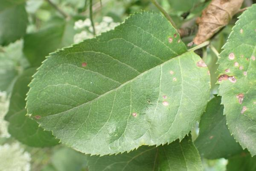

In [ ]:
sample_image = PILImage.create(files[0])
print(sample_image.size)
sample_image.to_thumb(256)

##  <font color = 'pickle'> Check size of all the images

In [ ]:
from fastcore.parallel import *

In [ ]:
def get_sizes(image):
    return PILImage.create(image).size

In [ ]:
sizes = parallel(get_sizes, files, progress=True)

In [ ]:
pd.Series(sizes).value_counts()

(600, 400)    12409
(600, 450)      627
(600, 600)        3
(450, 600)        2
(600, 337)        1
dtype: int64

# <font color = 'pickle'> Data Loader

In [ ]:
df = pd.read_csv(data_folder/'train.csv')

In [ ]:
df.head()

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13042 entries, 0 to 13041
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   13042 non-null  object
 1   labels  13042 non-null  object
dtypes: object(2)
memory usage: 203.9+ KB


In [ ]:
df.iloc[0:10, ] #multi-label classification

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex
5,train_image_6.jpg,rust
6,train_image_7.jpg,scab frog_eye_leaf_spot
7,train_image_8.jpg,scab frog_eye_leaf_spot
8,train_image_9.jpg,frog_eye_leaf_spot
9,train_image_10.jpg,frog_eye_leaf_spot


In [ ]:
# def get_x(df): return str(small_train_images) + '/' + (df['image'])

#get x and get y - and make a datablock
def get_x(df):
  return data_folder/'train/train'/df['image']
def get_y(df):
  return df['labels'].split(' ')

#instantiating a DataBlock
dblock = DataBlock(get_x= get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(seed = 42))
dsets = dblock.datasets(df)
dsets.train[15]

(Path('/content/inclass_kaggle_data/train/train/train_image_10535.jpg'),
 ['rust', 'complex'])

In [ ]:
# multi-label --> multi category block # 6 classes
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x= get_x,
                   get_y = get_y,
                  splitter = RandomSplitter(seed = 42))
dsets = dblock.datasets(df)
dsets.train[15]

(PILImage mode=RGB size=600x400, TensorMultiCategory([1., 0., 0., 0., 1., 0.]))

In [ ]:
dsets.train.vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [ ]:
idxs = torch.where(dsets.train[15][1] == 1.)[0]

In [ ]:
dsets.train.vocab[idxs]

(#2) ['complex','rust']

In [ ]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                  get_x= get_x,
                  get_y = get_y,
                  splitter = RandomSplitter(seed = 42),
                  item_tfms= Resize(400, method = 'squish'), #resizing --> no randomness here --> PIL-600,400||Pytorch (400,600)
                  batch_tfms= aug_transforms(size = 128, min_scale = 0.75))
dsets = dblock.datasets(df)
dsets.train[3]

(PILImage mode=RGB size=600x400, TensorMultiCategory([0., 0., 0., 0., 0., 1.]))

In [ ]:
import os
os.cpu_count()

12

In [ ]:
dls = dblock.dataloaders(df, bs = 64, num_workers =8)

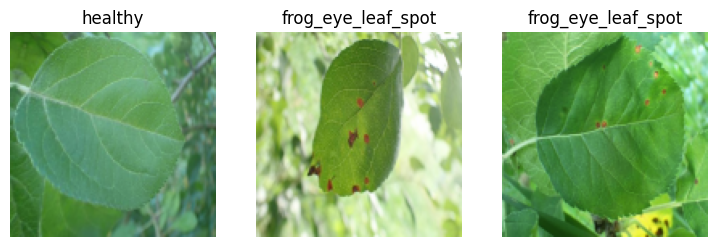

In [ ]:
dls.train.show_batch(max_n=3)

In [ ]:
dls.device

device(type='cuda', index=0)

# <font color = 'pickle'> Model

# **Experiment-1 (first submission)**

In [ ]:
f1score = F1ScoreMulti(thresh = 0.5) #you can tune the threshold here
loss_func = nn.BCEWithLogitsLoss() #multilabel classification
learn = vision_learner(dls,'resnet26d', metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16() #thresholds can change with the model

#use pretrained models train on leaf dataset

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.017378008365631102, steep=0.03981071710586548, valley=0.0014454397605732083, slide=0.010964781977236271)

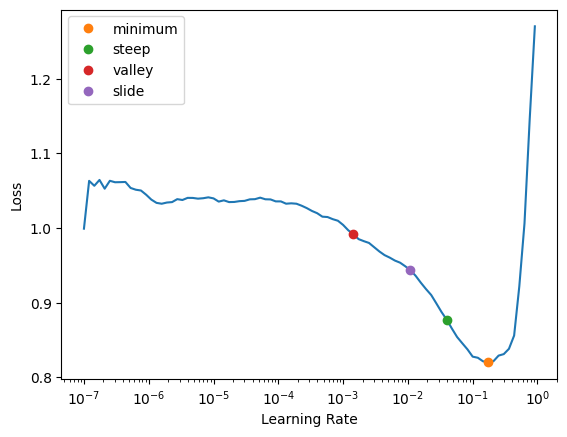

In [ ]:
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(3, 0.03)

epoch,train_loss,valid_loss,f1_score,time
0,0.385232,0.286225,0.641045,00:25


epoch,train_loss,valid_loss,f1_score,time
0,0.207971,0.164441,0.777985,00:28
1,0.144824,0.128324,0.842639,00:27
2,0.109313,0.120932,0.851159,00:28


# **Experiment-2 (second submission)**

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.017378008365631102, steep=0.03981071710586548, valley=0.0014454397605732083, slide=0.010964781977236271)

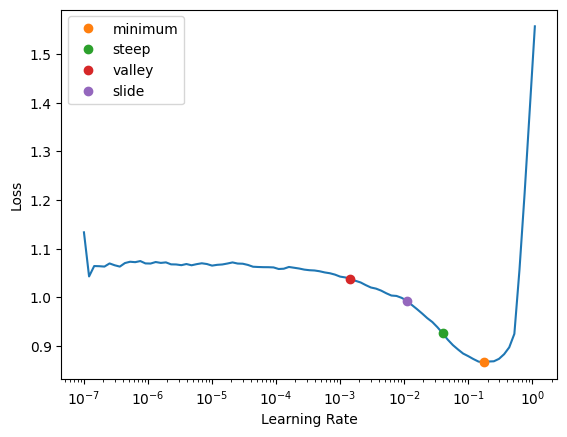

In [ ]:
learn = vision_learner(dls,'densenet121',metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16() #thresholds can change with the model
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))



In [ ]:
learn.fine_tune(7, 0.1)

epoch,train_loss,valid_loss,f1_score,time
0,0.389781,0.334441,0.588466,00:36


epoch,train_loss,valid_loss,f1_score,time
0,0.210107,0.187265,0.761689,00:41
1,0.197392,0.204644,0.756598,00:41
2,0.188635,0.172703,0.814759,00:41
3,0.152074,0.194784,0.834473,00:41
4,0.124339,0.132634,0.852445,00:41
5,0.097724,0.106996,0.871536,00:41
6,0.084418,0.108384,0.869686,00:41


# **Experiment-3**

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.02089296132326126, steep=0.03981071710586548, valley=0.0008317637839354575, slide=0.013182567432522774)

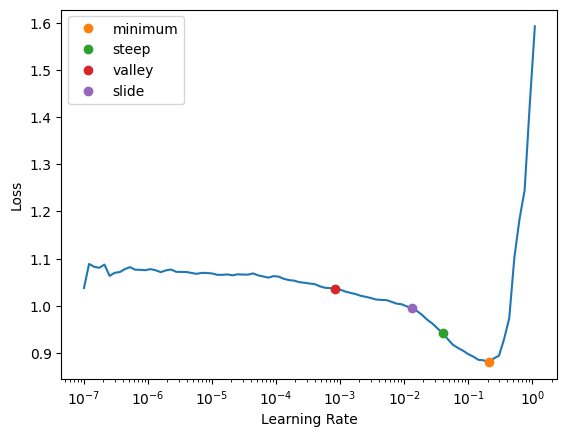

In [ ]:
learn = vision_learner(dls,'resnet152',metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16() #thresholds can change with the model
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))


In [ ]:
learn.fine_tune(7, 0.01)

epoch,train_loss,valid_loss,f1_score,time
0,0.466393,0.392757,0.431807,00:30


epoch,train_loss,valid_loss,f1_score,time
0,0.351383,0.327271,0.478832,00:34
1,0.325068,0.294714,0.551489,00:34
2,0.281143,0.264534,0.613094,00:35
3,0.252808,0.235323,0.664763,00:34
4,0.222169,0.216872,0.712868,00:34
5,0.207931,0.207237,0.707140,00:35
6,0.198703,0.207069,0.715450,00:35


# **Experiment-4 (third submission)**

SuggestedLRs(minimum=0.33113112449646, steep=0.0691830962896347, valley=0.010964781977236271, slide=0.05754399299621582)

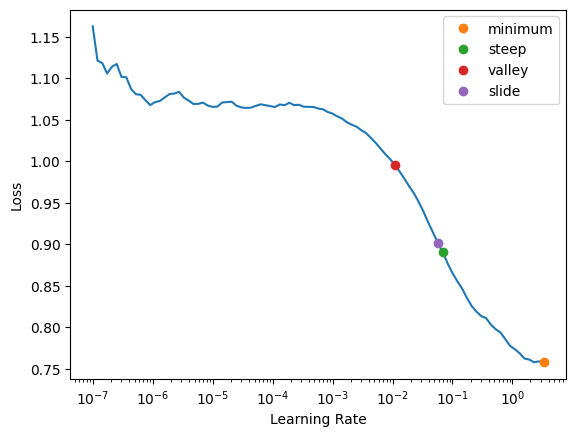

In [ ]:
learn = vision_learner(dls,'densenet161',metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16() #thresholds can change with the model
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(7, 0.01)

epoch,train_loss,valid_loss,f1_score,time
0,0.558982,0.401194,0.177967,00:52


epoch,train_loss,valid_loss,f1_score,time
0,0.140839,0.125114,0.849017,00:58
1,0.128390,0.119145,0.856765,00:59
2,0.121232,0.118965,0.861856,00:58
3,0.118142,0.117570,0.862248,00:58
4,0.117159,0.117427,0.861591,00:58
5,0.119816,0.117291,0.861886,00:58
6,0.114112,0.117047,0.861219,00:58


# **Experiment-5 (forth submission)**

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.02089296132326126, steep=0.03981071710586548, valley=0.0014454397605732083, slide=0.013182567432522774)

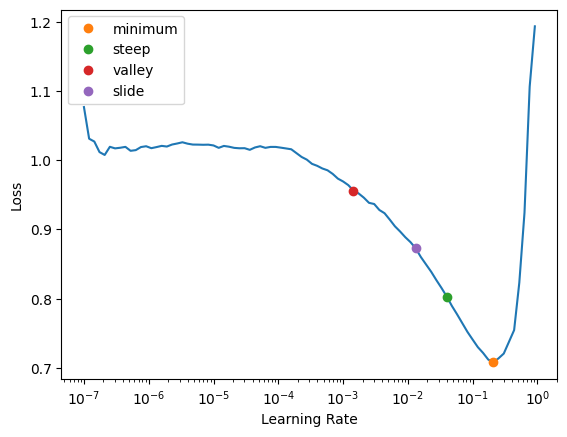

In [ ]:
learn = vision_learner(dls,'convnext_large',metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16() #thresholds can change with the model
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(7, 0.001)

epoch,train_loss,valid_loss,f1_score,time
0,0.125236,0.197693,0.873922,00:27


epoch,train_loss,valid_loss,f1_score,time
0,0.108605,0.148566,0.875120,00:30
1,0.100345,0.100381,0.884632,00:31
2,0.090924,0.095708,0.891015,00:31
3,0.088951,0.110473,0.896336,00:30
4,0.085399,0.126667,0.894469,00:30
5,0.078309,0.090560,0.896604,00:30
6,0.082907,0.122932,0.894772,00:30


**Training convnext large with less learning rate**

In [ ]:
learn.fine_tune(7, 0.0001)

epoch,train_loss,valid_loss,f1_score,time
0,0.806394,0.558181,0.502277,00:22


epoch,train_loss,valid_loss,f1_score,time
0,0.699609,0.524491,0.528312,00:31
1,0.646546,0.472636,0.574248,00:30
2,0.571632,0.417077,0.633860,00:30
3,0.523944,0.376521,0.680037,00:31
4,0.484703,0.349854,0.705945,00:30
5,0.466904,0.338407,0.720638,00:30
6,0.460724,0.341719,0.714058,00:31


# **Experiment-6**

model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.025118863582611083, steep=0.033113110810518265, valley=0.004365158267319202, slide=0.015848932787775993)

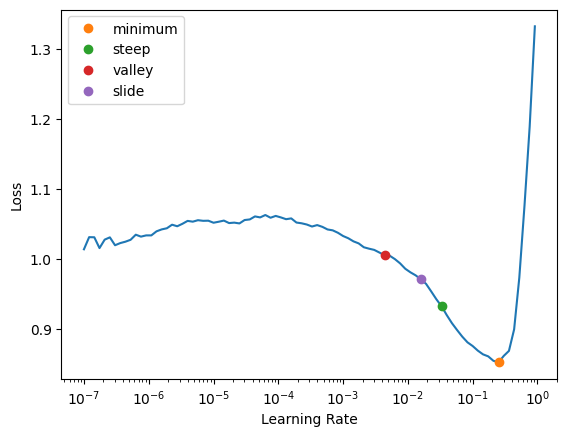

In [ ]:
learn = vision_learner(dls,'resnext101_64x4d',metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16() #thresholds can change with the model
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(7, 0.01)

epoch,train_loss,valid_loss,f1_score,time
0,0.156725,0.175944,0.799966,00:27


epoch,train_loss,valid_loss,f1_score,time
0,0.138166,0.143359,0.825834,00:29
1,0.123508,0.135192,0.824798,00:28
2,0.106758,0.131202,0.846586,00:28
3,0.084581,0.131556,0.860503,00:28
4,0.062399,0.131242,0.862940,00:28
5,0.048865,0.131783,0.865807,00:28
6,0.042188,0.136762,0.864831,00:28


# <font color ='pickle'> Find the threshold

In [ ]:
F1ScoreMulti??

In [ ]:
learn.metrics = F1ScoreMulti(thresh = 0.1)

In [ ]:
learn.metrics

(#1) [<fastai.metrics.AccumMetric object at 0x7ea7914b3f10>]

In [ ]:
learn.validate()

(#2) [0.12293187528848648,0.8575738402350658]

In [ ]:
learn.metrics = F1ScoreMulti(thresh = 0.9)

In [ ]:
learn.validate()

(#2) [0.12293187528848648,0.7766600631091473]

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
preds.shape, targs.shape

(torch.Size([2608, 6]), torch.Size([2608, 6]))

In [ ]:
f1score = F1ScoreMulti(thresh = None, sigmoid=False)

In [ ]:
idxs = (preds>0.5) * 1

In [ ]:
f1score(idxs, targs)

0.8947721979535886

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)

In [ ]:
f1scores = [f1score((preds>i) * 1, targs) for i in xs]

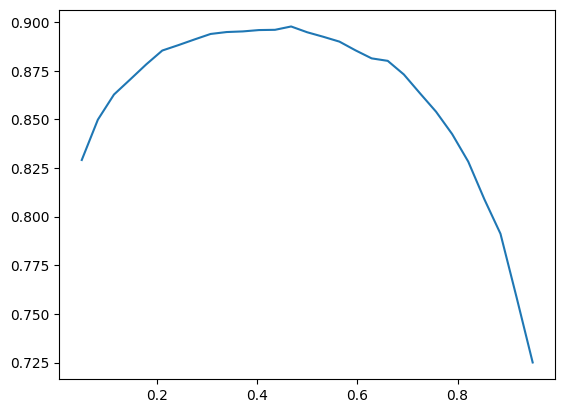

In [ ]:
plt.plot(xs, f1scores)

In [ ]:
torch.argmax(torch.tensor(f1scores))

tensor(13)

In [ ]:
xs[13]

tensor(0.4679)

In [ ]:
f1scores[13]

0.8977485709770213

# <font color ='pickle'>Test Predictions

In [ ]:
test_files = get_image_files(data_folder/'test/test').sorted()

In [ ]:
test_files

(#5590) [Path('/content/inclass_kaggle_data/test/test/test_image_1.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_10.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_100.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1000.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1001.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1002.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1003.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1004.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1005.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1006.jpg')...]

In [ ]:
test_dl = learn.dls.test_dl(test_files)

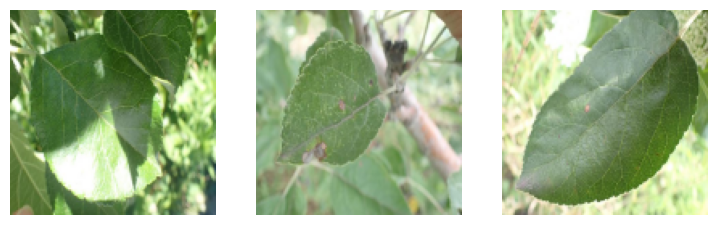

In [ ]:
test_dl.show_batch(max_n=3)

In [ ]:
preds, _ = learn.tta(dl = test_dl)

In [ ]:
preds

tensor([[1.6414e-03, 5.8797e-04, 9.8652e-01, 2.1508e-03, 2.5114e-04, 4.1453e-02],
        [8.0016e-01, 3.2712e-01, 1.0743e-03, 8.4630e-03, 1.5614e-02, 1.3629e-01],
        [3.9124e-01, 5.0617e-01, 3.8424e-04, 4.0209e-01, 1.2874e-03, 7.2319e-02],
        ...,
        [3.1595e-05, 9.5170e-06, 1.0000e+00, 1.5583e-09, 5.0131e-07, 1.0703e-04],
        [3.5923e-01, 8.3653e-01, 5.4309e-04, 1.4914e-03, 1.3279e-03, 9.2026e-02],
        [7.9884e-03, 2.4287e-03, 1.0724e-04, 9.9997e-01, 2.0798e-04, 5.0634e-04]])

In [ ]:
pred_decoded = [torch.where(pred>0.5)[0] for pred in preds]

In [ ]:
pred_decoded[0:20]

[tensor([2]),
 tensor([0]),
 tensor([1]),
 tensor([], dtype=torch.int64),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0, 5]),
 tensor([5]),
 tensor([2]),
 tensor([5]),
 tensor([2]),
 tensor([1]),
 tensor([5]),
 tensor([5]),
 tensor([0, 4]),
 tensor([2]),
 tensor([2]),
 tensor([5])]

In [ ]:
vocab = learn.dls.vocab

In [ ]:
pred_labels = [vocab[pred] for pred in pred_decoded[0:20]]

In [ ]:
pred_labels

[(#1) ['healthy'],
 (#1) ['complex'],
 (#1) ['frog_eye_leaf_spot'],
 (#0) [],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['complex'],
 (#2) ['complex','scab'],
 (#1) ['scab'],
 (#1) ['healthy'],
 (#1) ['scab'],
 (#1) ['healthy'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['scab'],
 (#1) ['scab'],
 (#2) ['complex','rust'],
 (#1) ['healthy'],
 (#1) ['healthy'],
 (#1) ['scab']]

In [ ]:
[" ".join(pred)for pred in pred_labels]

['healthy',
 'complex',
 'frog_eye_leaf_spot',
 '',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'complex',
 'complex scab',
 'scab',
 'healthy',
 'scab',
 'healthy',
 'frog_eye_leaf_spot',
 'scab',
 'scab',
 'complex rust',
 'healthy',
 'healthy',
 'scab']

In [ ]:
pred_labels = [' '.join(vocab[torch.where(pred>0.34)[0]]) for pred in preds]

In [ ]:
pred_labels[0:20]

['healthy',
 'complex',
 'complex frog_eye_leaf_spot powdery_mildew',
 'frog_eye_leaf_spot',
 'complex frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'complex frog_eye_leaf_spot',
 'complex scab',
 'scab',
 'healthy',
 'scab',
 'healthy',
 'frog_eye_leaf_spot',
 'scab',
 'scab',
 'complex rust',
 'healthy',
 'healthy',
 'scab']

# <font color ='pickle'> Kaggle Submission

In [ ]:
sample_submission= pd.read_csv(data_folder/'sample_submission.csv')

In [ ]:
sample_submission

,image,labels
0,test_image_1.jpg,healthy
1,test_image_2.jpg,healthy
2,test_image_3.jpg,healthy
3,test_image_4.jpg,healthy
4,test_image_5.jpg,healthy
...,...,...
5585,test_image_5586.jpg,healthy
5586,test_image_5587.jpg,healthy
5587,test_image_5588.jpg,healthy
5588,test_image_5589.jpg,healthy


In [ ]:
sample_submission = sample_submission.sort_values(by = 'image')


In [ ]:
sample_submission

,image,labels
0,test_image_1.jpg,healthy
9,test_image_10.jpg,healthy
99,test_image_100.jpg,healthy
999,test_image_1000.jpg,healthy
1000,test_image_1001.jpg,healthy
...,...,...
994,test_image_995.jpg,healthy
995,test_image_996.jpg,healthy
996,test_image_997.jpg,healthy
997,test_image_998.jpg,healthy


In [ ]:
sample_submission['labels'] = pred_labels

In [ ]:
sample_submission

,image,labels
0,test_image_1.jpg,healthy
9,test_image_10.jpg,complex
99,test_image_100.jpg,complex frog_eye_leaf_spot powdery_mildew
999,test_image_1000.jpg,frog_eye_leaf_spot
1000,test_image_1001.jpg,complex frog_eye_leaf_spot
...,...,...
994,test_image_995.jpg,powdery_mildew
995,test_image_996.jpg,healthy
996,test_image_997.jpg,healthy
997,test_image_998.jpg,complex frog_eye_leaf_spot


In [ ]:
sample_submission.to_csv(model_folder/'first_sub.csv', index = False)

In [ ]:
!head {model_folder/'first_sub.csv'}

image,labels
test_image_1.jpg,healthy
test_image_10.jpg,complex
test_image_100.jpg,complex frog_eye_leaf_spot powdery_mildew
test_image_1000.jpg,frog_eye_leaf_spot
test_image_1001.jpg,complex frog_eye_leaf_spot
test_image_1002.jpg,frog_eye_leaf_spot
test_image_1003.jpg,frog_eye_leaf_spot
test_image_1004.jpg,complex frog_eye_leaf_spot
test_image_1005.jpg,complex scab


In [ ]:
comp = 'inclassplantpathologysmallf23'
api.competition_submit(model_folder/'first_sub.csv', 'inclass dec04', comp)

100%|██████████| 169k/169k [00:03<00:00, 56.5kB/s]


Successfully submitted to Inclass_Plant_Pathology_Small_F23

**Conclusion**:

I conducted experiments with six distinct convolutional models and found that the ConvNext_Large model, submitted as my fourth entry on Kaggle, yielded the highest performance. Specifically, it achieved an impressive F1-score of 89.47% on the validation set. When applied to Kaggle's test dataset, the model maintained a strong F1-score of approximately 83.15%.


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [6]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle/Pooja_Akkaladevi_HW8b_Final_Submission.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/Plant_Pathology_detection_Kaggle/Pooja_Akkaladevi_HW8b_Final_Submission.ipynb to pdf
[NbConvertApp] Support files will be in Pooja_Akkaladevi_HW8b_Final_Submission_files/
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW8b_Final_Submission_files
[NbConvertApp] Making directory .